## Imports

In [4]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit, prange
from pyccel.epyccel import epyccel
from pyccel.decorators import types
import subprocess
import os
import shutil
import sys
import re
import pytest
import time

## Pure python function

In [5]:
def solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy, c):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
 
 u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
 v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
 row, col = u.shape
 for n in range(nt + 1): ##loop across number of time steps
    un = u.copy()
    vn = v.copy() 
    u[1:, 1:] = (un[1:, 1:] - 
                 (un[1:, 1:] * c * dt / dx * (un[1:, 1:] - un[1:, :-1])) -           ## we  will be vectorized our code here !!
                  vn[1:, 1:] * c * dt / dy * (un[1:, 1:] - un[:-1, 1:]))
    v[1:, 1:] = (vn[1:, 1:] -
                 (un[1:, 1:] * c * dt / dx * (vn[1:, 1:] - vn[1:, :-1])) -
                 vn[1:, 1:] * c * dt / dy * (vn[1:, 1:] - vn[:-1, 1:]))
    
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1


         
    
    #fill the update of u and v
        
 return 0

## Numba accelerator

In [6]:
@njit(parallel=True,fastmath=True,nopython=True) 
def solve_2d_nonlinearconv_numba(u, un, v, vn, nt, dt, dx, dy, c):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
 u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
 v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
 row, col = u.shape
 for n in prange(nt + 1): #
    un = u.copy()                               ## we  will be vectorized our code here !!
    vn = v.copy()
    u[1:, 1:] = (un[1:, 1:] - 
                 (un[1:, 1:] * c * dt / dx * (un[1:, 1:] - un[1:, :-1])) -
                  vn[1:, 1:] * c * dt / dy * (un[1:, 1:] - un[:-1, 1:]))
    v[1:, 1:] = (vn[1:, 1:] -
                 (un[1:, 1:] * c * dt / dx * (vn[1:, 1:] - vn[1:, :-1])) -
                 vn[1:, 1:] * c * dt / dy * (vn[1:, 1:] - vn[:-1, 1:]))
    
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1
    #fill the update of u and v
    
 return 0

/home/babou/.local/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Pyccel accelerator

In [21]:
@types('float[:,:]', 'float[:,:]','float[:,:]','float[:,:]', 'int' ,'float', 'float','float', 'float')

def solve_2d_nonlinearconv_pyccel(u, un, v, vn, nt, dt, dx, dy, c):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    for it in range(0, nt):
           un [:,:]= u[:,:]
           vn[:,:] = v[:,:]
           for i in range(1, row):
                for j in range(1, col): 
    
                  u[i,j]=(un[i,j]-un[i,j]*(dt/dx)* 
                          (un[i,j]-un[i-1,j])-
                             vn[i,j]*(dt/dy)*(un[i,j]-un[i,j-1]))
                  v[i,j]= (vn[i,j]-un[i,j]*(dt/dx)* 
                          (vn[i,j]-vn[i-1,j])-
                             vn[i,j]*(dt/dy)*(vn[i,j]-vn[i,j-1]))
           u[0, :] = 1
           u[-1, :] = 1
           u[:, 0] = 1
           u[:, -1] = 1
    
           v[0, :] = 1
           v[-1, :] = 1
           v[:, 0] = 1
           v[:, -1] = 1

        
    return 0

## Inputs

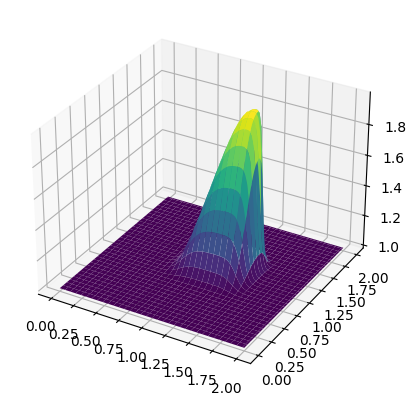

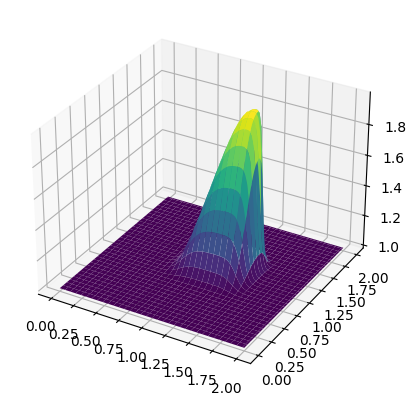

In [22]:
###variable declarations
nx = 101
ny = 101
nt = 80
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx)) ##create a 1xn vector of 1's
v = np.ones((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))     

solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy, c)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)


fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, v, cmap=cm.viridis)

## Call Funtions

### Pure function

In [23]:
%timeit solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy, c)

18.8 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Function with numba accelerator

In [24]:
%timeit solve_2d_nonlinearconv_numba(u, un, v, vn, nt, dt, dx, dy, c)

3.13 ms ± 736 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Function with pyccel accelerator

In [25]:
solve_2d_nonlinearconv_f90 = epyccel(solve_2d_nonlinearconv_pyccel)

In [26]:
%timeit solve_2d_nonlinearconv_f90(u, un, v, vn, nt, dt, dx, dy, c)

2.58 ms ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
